# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from matplotlib import pyplot

%matplotlib inline

In [2]:
# read raw files
coffee_data = pd.read_excel('coffee_data.xlsx')
fuel_data = pd.read_excel('fuel_data.xlsx')
weather_data = pd.read_excel('weather_data.xlsx')

# ---------- Data Pre-Processing -----------

### Filter Coffee data

In [3]:
coffee_data['Ngày'] = pd.to_datetime(coffee_data['Ngày'])
# fill up missing dates
coffee_data = coffee_data.set_index('Ngày').resample('D').ffill().reset_index()

### Filter Diesel data

In [4]:
fuel_data["Ngày"] = pd.to_datetime(fuel_data["Ngày"], format="%d.%m.%Y")
# reverse the order
fuel_data = fuel_data[::-1]

### Filter Weather Data

In [5]:
weather_data["time"] = pd.to_datetime(weather_data["time"], format="%d.%m.%Y")

# ---------- Calculate Weather -----------

In [6]:
# Total precipitation by each year

year2020 = (weather_data['time'] >= '2020-1-1') & (weather_data['time'] <= '2020-12-31')
df2 = weather_data.loc[year2020]
prec2020 = df2["precipitation_sum (mm)"].sum()

year2021 = (weather_data['time'] >= '2021-1-1') & (weather_data['time'] <= '2021-12-31')
df2 = weather_data.loc[year2021]
prec2021 = df2["precipitation_sum (mm)"].sum()

year2022 = (weather_data['time'] >= '2022-1-1') & (weather_data['time'] <= '2022-12-31')
df2 = weather_data.loc[year2022]
prec2022 = df2["precipitation_sum (mm)"].sum()

# ---------- Merge Data ----------

In [7]:
# Merge the dataframes with an outer join
merged_df = pd.merge(coffee_data, fuel_data, left_on='Ngày', right_on='Ngày', how="outer")

# Fill missing dates from both datasets with each other
merged_df.fillna(method='bfill', inplace=True)

In [8]:
# Create new column
merged_df['Precipitation (mm)'] = ""

In [9]:
# Fill in weather value

# precipitation
merged_df['Precipitation (mm)'] = np.where(merged_df['Ngày'] >= '2021-1-1', prec2020, merged_df['Precipitation (mm)'])
merged_df['Precipitation (mm)'] = np.where(merged_df['Ngày'] >= '2022-1-1', prec2021, merged_df['Precipitation (mm)'])
merged_df['Precipitation (mm)'] = np.where(merged_df['Ngày'] >= '2023-1-1', prec2022, merged_df['Precipitation (mm)'])

In [10]:
merged_df = merged_df.dropna() # Drop N/A rows
data = merged_df

# convert to float
data['Precipitation (mm)'] = data['Precipitation (mm)'].astype(float)

In [11]:
data

,Ngày,Giá Cà Phê,Giá Diesel 1 lít,Precipitation (mm)
0,2021-01-01,31667.5,12640.0,1174.199994
1,2021-01-02,31667.5,12640.0,1174.199994
2,2021-01-03,31667.5,12640.0,1174.199994
3,2021-01-04,32717.0,12640.0,1174.199994
4,2021-01-05,32417.0,12640.0,1174.199994
...,...,...,...,...
864,2023-05-15,55566.5,14900.0,1259.800013
865,2023-05-16,56066.5,14900.0,1259.800013
866,2023-05-17,56666.5,14900.0,1259.800013
867,2023-05-18,57000.0,14900.0,1259.800013


# ---------- Indentify Outliers -----------

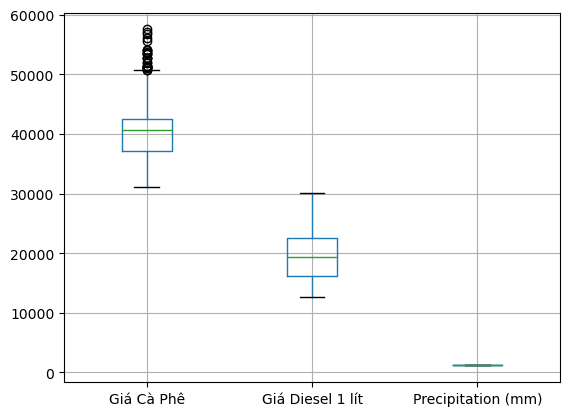

In [12]:
boxplot = data.boxplot()  

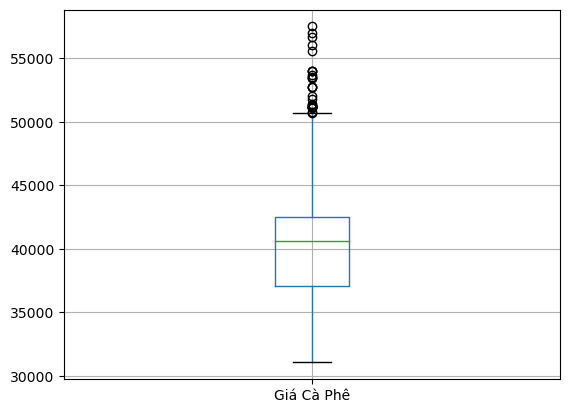

In [13]:
# further inspecting coffee outliers
boxplot = coffee_data.boxplot()  

In [14]:
# detecting outliers
outlier = np.where(coffee_data['Giá Cà Phê'] > 50000)

# removing outliers
data.drop(index=outlier[0], inplace=True)

data

,Ngày,Giá Cà Phê,Giá Diesel 1 lít,Precipitation (mm)
0,2021-01-01,31667.5,12640.0,1174.199994
1,2021-01-02,31667.5,12640.0,1174.199994
2,2021-01-03,31667.5,12640.0,1174.199994
3,2021-01-04,32717.0,12640.0,1174.199994
4,2021-01-05,32417.0,12640.0,1174.199994
...,...,...,...,...
825,2023-04-06,49766.5,20140.0,1259.800013
826,2023-04-07,49566.5,20140.0,1259.800013
827,2023-04-08,49566.5,20140.0,1259.800013
828,2023-04-09,49566.5,20140.0,1259.800013


# ---------- Time Series Chart -----------

Text(0, 0.5, 'Values')

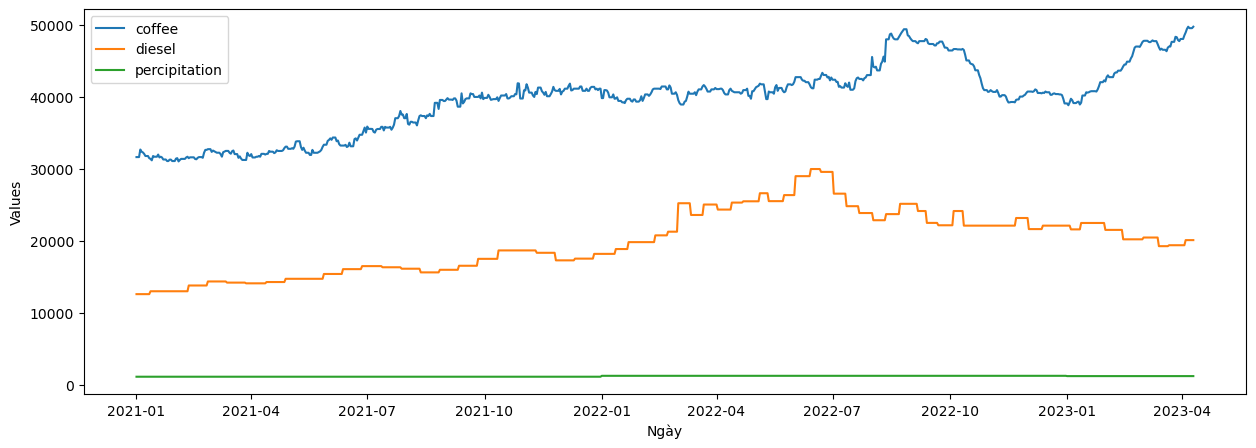

In [15]:
plt.figure(figsize=(15,5))

sns.lineplot(x="Ngày", y="Giá Cà Phê", data=data, label='coffee')
sns.lineplot(x="Ngày", y="Giá Diesel 1 lít", data=data, label='diesel')
sns.lineplot(x="Ngày", y="Precipitation (mm)", data=data, label='percipitation')

# set label
plt.ylabel("Values")

# ---------- Correlation ----------

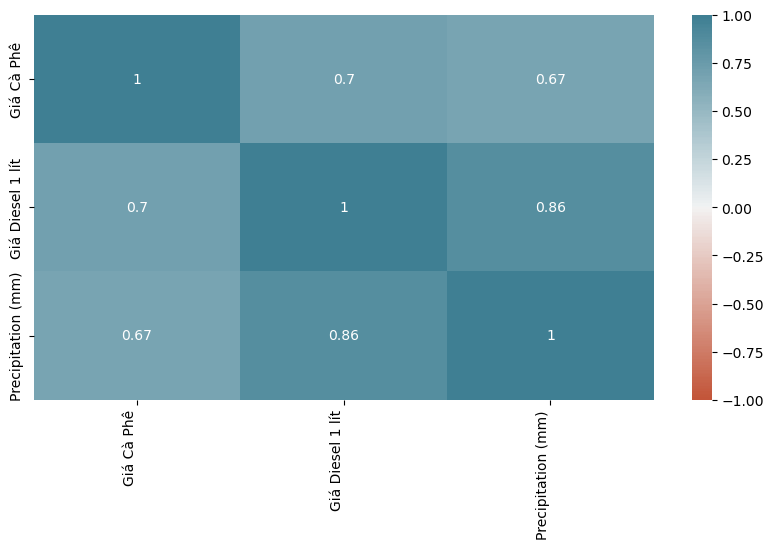

In [16]:
# # Use heatmap to identify correlation between variables
f, ax = plt.subplots(figsize = (10, 5))
corr = data.corr()
ax = sns.heatmap(
    corr, vmin = -1, vmax = 1, center = 0, annot = True,
    cmap = sns.diverging_palette(20, 220, n = 200),
    square = False
)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, horizontalalignment = 'right');

# ---------- Write to file ----------

In [17]:
# Export the final dataset to excel
data.to_excel('data.xlsx', index=False)